In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [3]:
# Save the input and target variables
print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean()) / targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [5]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape, test_data.shape, train_targets.shape, test_targets.shape)

(397, 10) (45, 10) (397,) (45,)


#### Train a feedforward neural network model

In [6]:
# Build the model


def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return model

model = get_model()

In [7]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [9]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [10]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.8750 - mae: 0.8085


[1.1148564603593614, 0.8084952]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

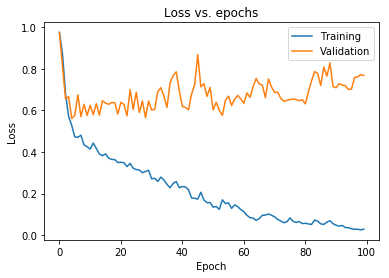

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd), input_shape=(train_data.shape[1],)),
        Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        tf.keras.layers.Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [16]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [17]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [18]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5330 - mae: 0.6682


[0.7086962905195024, 0.66818506]

#### Plot the learning curves

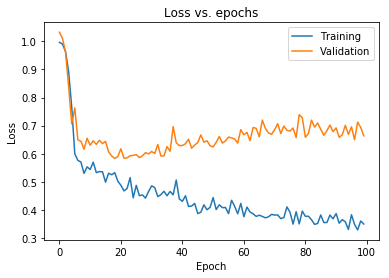

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Start Training")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Training: Statring Epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting Batch: {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished Batch: {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Ending Epoch: {epoch}")
        
    def on_train_end(self, logs=None):
        print("Fininished Training")
        
class TestingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Start Testing")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Testing: Statring Epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting Batch: {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Testing: Finished Batch: {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Ending Epoch: {epoch}")
        
    def on_train_end(self, logs=None):
        print("Fininished Testing")

In [21]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [22]:
# Compile the model

model.compile(optimizer="adam", loss="mse")

#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation

history = model.fit(
    train_data, train_targets, epochs=3, 
    validation_split=0.15, batch_size=64, 
    verbose=False, callbacks=[TrainingCallback()]
)

Start Training
Training: Statring Epoch 0
Training: Starting Batch: 0
Training: Finished Batch: 0
Training: Starting Batch: 1
Training: Finished Batch: 1
Training: Starting Batch: 2
Training: Finished Batch: 2
Training: Starting Batch: 3
Training: Finished Batch: 3
Training: Starting Batch: 4
Training: Finished Batch: 4
Training: Starting Batch: 5
Training: Finished Batch: 5
Ending Epoch: 0
Training: Statring Epoch 1
Training: Starting Batch: 0
Training: Finished Batch: 0
Training: Starting Batch: 1
Training: Finished Batch: 1
Training: Starting Batch: 2
Training: Finished Batch: 2
Training: Starting Batch: 3
Training: Finished Batch: 3
Training: Starting Batch: 4
Training: Finished Batch: 4
Training: Starting Batch: 5
Training: Finished Batch: 5
Ending Epoch: 1
Training: Statring Epoch 2
Training: Starting Batch: 0
Training: Finished Batch: 0
Training: Starting Batch: 1
Training: Finished Batch: 1
Training: Starting Batch: 2
Training: Finished Batch: 2
Training: Starting Batch: 3
Trai

In [24]:
# Evaluate the model
model.evaluate(test_data, test_targets, callbacks=[TestingCallback()], verbose=False)


0.9158299883206685

In [25]:
# Make predictions with the model
class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Start Predicting")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Predicting: Statring Epoch {epoch}")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Predicting: Starting Batch: {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Predicting: Finished Batch: {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Ending Epoch: {epoch}")
        
    def on_predict_end(self, logs=None):
        print("Fininished Predicting")
        
        
model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])


Start Predicting
Predicting: Starting Batch: 0
Predicting: Finished Batch: 0
Predicting: Starting Batch: 1
Predicting: Finished Batch: 1
Fininished Predicting


array([[ 0.01245211],
       [ 0.06299499],
       [-0.08192705],
       [-0.10809854],
       [-0.10349406],
       [-0.2041992 ],
       [-0.0005782 ],
       [-0.04316958],
       [-0.14435571],
       [ 0.06981979],
       [-0.03478132],
       [-0.08612239],
       [ 0.12043303],
       [-0.07513615],
       [ 0.00181189],
       [-0.04152381],
       [ 0.03796742],
       [-0.0856239 ],
       [-0.16755131],
       [-0.18357937],
       [-0.10832629],
       [-0.07183535],
       [-0.20095679],
       [ 0.03295857],
       [ 0.05147726],
       [ 0.02503067],
       [ 0.15579908],
       [-0.10792956],
       [ 0.08306369],
       [ 0.13095747],
       [-0.19225383],
       [-0.09034391],
       [ 0.13599837],
       [-0.15804943],
       [ 0.00945558],
       [-0.20646209],
       [-0.00087493],
       [-0.10859793],
       [ 0.06885966],
       [ 0.09638896],
       [-0.18121852],
       [-0.12582359],
       [-0.10134883],
       [-0.15680094],
       [-0.11361639]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [40]:
# Re-train the unregularised model
unregularized_model = get_model()
unregularized_model.compile(optimizer="adam", loss="mae")
unreg_history = unregularized_model.fit(
    train_data, train_targets, epochs=100, verbose=False,
    validation_split=0.15, batch_size=64, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]                                   
)


In [41]:
# Evaluate the model on the test set
unregularized_model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.5256


0.5987071739302741

In [42]:
# Re-train the regularised model
regularized_model = get_regularised_model(1e-8, 0.2)

regularized_model.compile(optimizer="adam", loss="mae")
reg_history = regularized_model.fit(
    train_data, train_targets, epochs=100, verbose=False,
    validation_split=0.15, batch_size=64, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]                                   
)

In [43]:
# Evaluate the model on the test set
regularized_model.evaluate(test_data, test_targets, verbose=2)



45/1 - 0s - loss: 0.5344


0.6040384941630893

#### Plot the learning curves

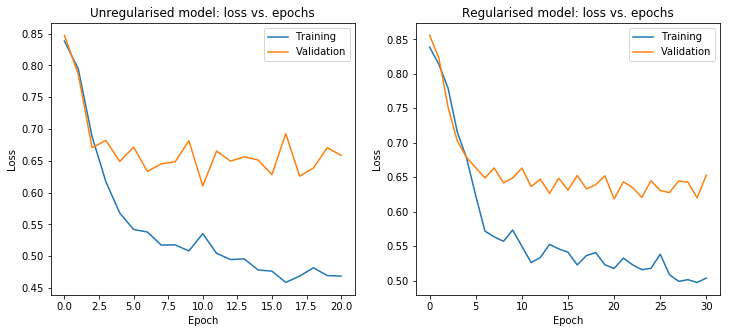

In [44]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()